In [9]:
import pretty_midi
import glob
import numpy as np
import gensim
import music21
import sklearn
import random
import json


from matplotlib import pyplot as plt
%matplotlib inline

from bokeh.plotting import output_file, output_notebook, ColumnDataSource, figure, show
from bokeh.models import HoverTool

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

In [178]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

def transpose_to_all(c):
    out = []
    old = c
    for i in range(12):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out

def transpose_to_some(c, degree):
    out = []
    out.append(c)
    old = c
    for i in range(degree):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out
        
def c_to_strep(c):
    rep = ""
    for i in range(12):
        if i in c.pitchClasses:
            rep += "1"
        else:
            rep += "0"
    return rep

def strep_to_c(strep):
    pcs = []
    for i, v in enumerate(strep):
        if v == '1':
            pcs.append(i)
    return music21.chord.Chord(pcs)

def strep_to_symbol(strep):
    c = strep_to_c(strep)
    return music21.harmony.chordSymbolFigureFromChord(c)

In [179]:
ns = {}
tok_counts = {}

for subcorpus in glob.glob('*.json'):
    with open(subcorpus, 'r') as f:
        subc = json.load(f)
        ns[subcorpus] = len(subc)
        tok_counts[subcorpus] = sum([len(d) for d in subc])
        

In [180]:
ns, tok_counts

({'1650_to_1699.json': 339,
  '1700_to_1749.json': 2120,
  '1750_to_1799.json': 1806,
  '1800_to_1849.json': 1770,
  '1850_to_1899.json': 1601,
  '1900_to_1950.json': 487,
  'Bach.json': 652,
  'Beethoven.json': 366,
  'Brahms.json': 166,
  'Chopin.json': 204,
  'Dvorak.json': 117,
  'Handel.json': 191,
  'Haydn.json': 363,
  'Hummel.json': 101,
  'Liszt.json': 125,
  'Mendelssohn.json': 137,
  'Mozart.json': 882,
  'Saint-Saens.json': 137,
  'Scarlatti.json': 617,
  'Schubert.json': 223,
  'Schumann.json': 167,
  'Tchaikovsky.json': 94,
  'Telemann.json': 224,
  'Verdi.json': 91,
  'Vivaldi.json': 167,
  'Wagner.json': 58,
  'ycac.json': 8478},
 {'1650_to_1699.json': 235296,
  '1700_to_1749.json': 1892572,
  '1750_to_1799.json': 2820522,
  '1800_to_1849.json': 3565872,
  '1850_to_1899.json': 2635754,
  '1900_to_1950.json': 630992,
  'Bach.json': 455154,
  'Beethoven.json': 885337,
  'Brahms.json': 291608,
  'Chopin.json': 326281,
  'Dvorak.json': 236525,
  'Handel.json': 192675,
  'Ha

In [182]:
def generate_embeddings(composer, sample_size=None):
    docs = json.load(open('{}'.format(composer)))
    
    if sample_size is None:
        docs = docs
    else:
        docs = random.sample(docs, sample_size)
    
    chunked_docs = []

    for doc in docs:
        chunked_docs.extend([x for x in chunks(doc, 32)])
        
    sentences = chunked_docs

    model =
    
    return model

In [183]:
def plot_relations(a, b, composer, sample_size=None,model=None):
    
    if model is None:
        model = generate_embeddings(composer, sample_size)
    
    if sample_size is None:
        n = ns[composer]
    else:
        n = sample_size
    
    words = model.vocab.keys()
    embeddings = np.array([model[w] for w in words])
    
    # tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=200)
    pca = PCA(n_components=2)
    proj = pca.fit_transform(embeddings)

    all_a = [c_to_strep(x) for x in transpose_to_all(a)]
    all_b = [c_to_strep(x) for x in transpose_to_all(b)]

    pairs = zip(all_a, all_b)
    focus = all_a + all_b
    
    q_words = [x for x in model.vocab.keys() if x in focus]
    
    q_indices = [words.index(x) for x in q_words]
    
    x=proj[q_indices,0]
    y=proj[q_indices,1]

    labels = [" ".join(strep_to_c(w).pitchNames) for w in q_words]
    
    f, ax = plt.subplots()

    for lxy in zip(labels, x, y):
        ax.annotate(lxy[0], (lxy[1],lxy[2]))
        
    def lookup_strep(strep):
        i = words.index(strep)
        return (proj[i, 0], proj[i, 1])
        
    arrows = [map(lookup_strep, pair) for pair in pairs]

    arrow_params = {'length_includes_head': True,
                    'head_starts_at_zero': True}
    
    for arrow in arrows:
        ax.arrow(arrow[0][0], arrow[0][1], arrow[1][0] - arrow[0][0], arrow[1][1] - arrow[0][1], alpha=0.3, 
             linewidth=1, head_width=.05, head_length=.05, **arrow_params)
    
    ax.scatter(x, y, c='black')
        
    ax.set_title('{composer} (no. of docs = {n}) PCA'.format(composer=composer, n=n))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    f.show()

In [184]:
def plot_one(a, composer, sample_size=None, model=None):
    
    if model is None:
        model = generate_embeddings(composer, sample_size)
        
    if sample_size is None:
        n = ns[composer]
    else:
        n = sample_size
    
    words = model.vocab.keys()
    embeddings = np.array([model[w] for w in words])
    
    # tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=200)
    pca = PCA(n_components=2)
    proj = pca.fit_transform(embeddings)
    
    focus = [c_to_strep(x) for x in transpose_to_all(a)] 
    
    q_words = [x for x in model.vocab.keys() if x in focus]
    
    q_indices = [words.index(x) for x in q_words]
    
    x=proj[q_indices,0]
    y=proj[q_indices,1]

    labels = [" ".join(strep_to_c(w).pitchNames) for w in q_words]
    
    f, ax = plt.subplots()

    for lxy in zip(labels, x, y):
        ax.annotate(lxy[0], (lxy[1],lxy[2]))
    
    ax.scatter(x, y, c='black')
        
    ax.set_title('{composer} (no. of docs = {n}) PCA'.format(composer=composer, n=n))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    f.show()

In [196]:
def plot_collection(collection, composer, sample_size=None, transpose=False, model=None, colors=None):
    
    if model is None:
        model = generate_embeddings(composer, sample_size)
        
    if sample_size is None:
        n = ns[composer]
    else:
        n = sample_size
    
    words = model.vocab.keys()
    embeddings = np.array([model[w] for w in words])
    
    pca = PCA(n_components=2)
    proj = pca.fit_transform(embeddings)
        
    a = []
    
    if transpose:
        for x in collection:
            a.extend(transpose_to_some(x, degree=2))
    else:
        a = collection
        
        
    focus = [c_to_strep(x) for x in a] 
    
    q_words = [x for x in model.vocab.keys() if x in focus]
    
    q_indices = [words.index(x) for x in q_words]
    
    x=proj[q_indices,0]
    y=proj[q_indices,1]
    
    labels = [" ".join(strep_to_c(w).pitchNames) for w in q_words]
    
    f, ax = plt.subplots()

    for lxy in zip(labels, x, y):
        ax.annotate(lxy[0], (lxy[1],lxy[2]))
        
    if colors is None:
        ax.scatter(x, y, c='black')
    else:
        ax.scatter(x, y, c=colors)
        
    ax.set_title('{composer} (no. of docs = {n}) PCA'.format(composer=composer, n=n))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    f.show()

In [197]:
neighborhood = [
music21.chord.Chord(['C', 'E', 'G']),
 music21.chord.Chord(['C', 'E', 'G', 'B-']),
]

In [198]:
colors = []
chords = []
palette = ['blue', 'green', 'red', 'yellow', 'orange']

for i in range(5):
    for c in neighborhood:
        chords.append(c.transpose(i*2))
        colors.append(palette[i])
    

In [219]:
w2v = gensim.models.Word2Vec()
m = mod.load('ycac.json.model')

In [243]:
# similarity queries

major = music21.chord.Chord(['C', 'E', 'G'])
c_to_strep(major)
result = m.most_similar(c_to_strep(major), topn=10)

for strep, dist in result:
    print("\\langle {} \\rangle & {} & {:.2f} \\\\".format(", ".join(strep_to_c(strep).pitchNames), strep_to_symbol(strep), dist))
    print("\hline")

\langle C, D, E, G \rangle & CaddD & 0.65 \\
\hline
\langle C, E, F, G \rangle & CaddF & 0.61 \\
\hline
\langle C, E, G, B \rangle & Cmaj7 & 0.59 \\
\hline
\langle C, D, E, F, G \rangle & CaddD,F & 0.56 \\
\hline
\langle C, E, F#, G \rangle & CaddF# & 0.55 \\
\hline
\langle C, E-, E, F#, G \rangle & CmaddF#,E & 0.55 \\
\hline
\langle C, E-, E, G \rangle & CmaddE & 0.52 \\
\hline
\langle C, E, G, G# \rangle & CaddG# & 0.48 \\
\hline
\langle C, E, G, A \rangle & Am7/C & 0.48 \\
\hline
\langle C, E \rangle & Chord Symbol Cannot Be Identified & 0.46 \\
\hline


In [242]:
pca_neighbors = []

for strep, dist in result:
    pca_neighbors.append(strep_to_c(strep))

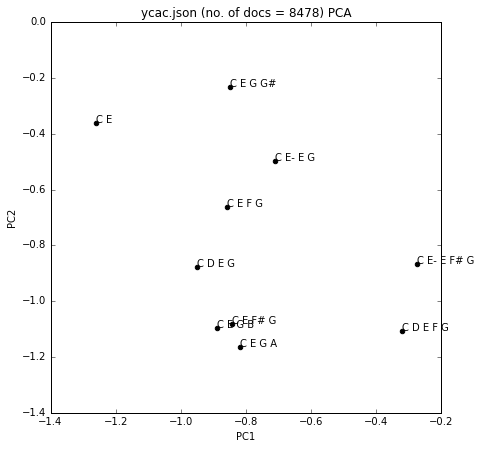

In [224]:
plot_collection(pca_neighbors, 'ycac.json', model=m)

In [41]:
model_names = [
    '1700_to_1749.json',
    '1750_to_1799.json',                
    '1800_to_1849.json',
    '1850_to_1899.json',
    'ycac.json'
              ]

def gen_all():
    for model_name in model_names:
        m = generate_embeddings(model_name)
        m.save('{}.model'.format(model_name))
        print('{} trained and saved'.format(model_name))

In [44]:
a = music21.chord.Chord(['G', 'B', 'D'])
b = music21.chord.Chord(['C', 'E', 'G'])

In [ ]:
coll = music21.chord

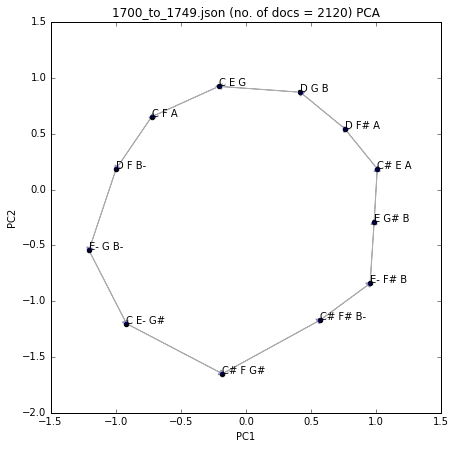

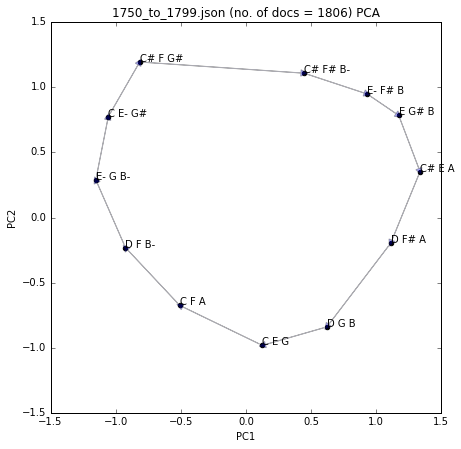

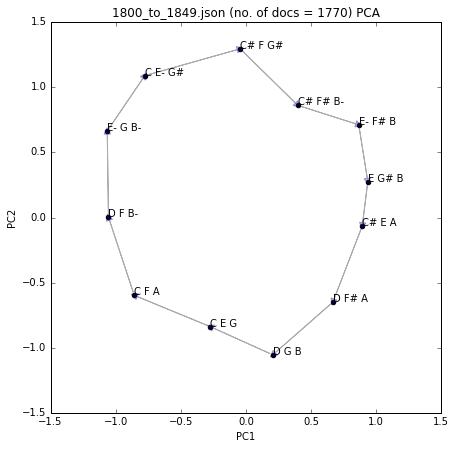

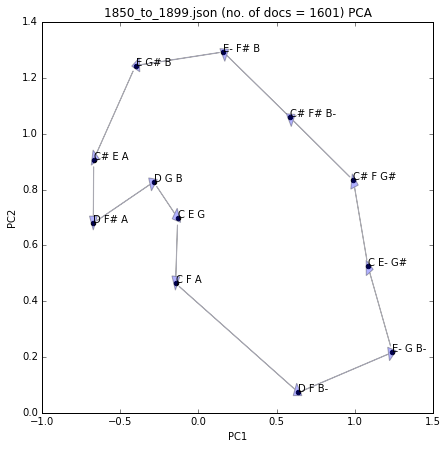

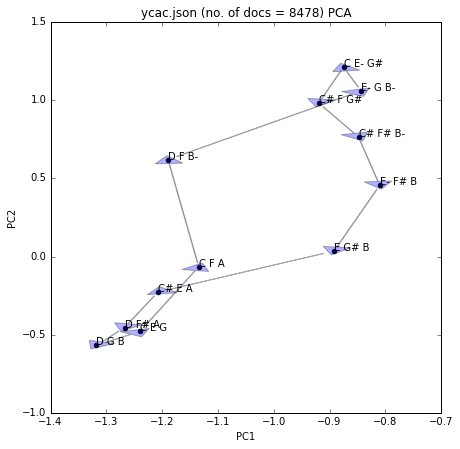

In [45]:
for model_name in model_names:
    w2v = gensim.models.Word2Vec()
    m = mod.load('{}.model'.format(model_name))
    plot_relations(a, b, '{}'.format(model_name), sample_size=None, model=m)